# idinvert: GAN inversion

## [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ml4a/ml4a-guides/blob/ml4a.net/examples/models/idinvert.ipynb)

Invert (encode) real images into the latent space of a pre-trained domain-specific [StyleGAN2](https://github.com/NVLabs/stylegan2/), so as to perform generative modeling operations on it, including fusing it into a separate image in the same domain, interpolating between real images, and editing salient features, such as (in the case of faces) age, gender, pose, and expression. See the [original code](https://github.com/genforce/idinvert_pytorch) and [paper](https://arxiv.org/pdf/2004.00049.pdf).

## Set up ml4a

If you don't already have ml4a and its dependencies installed, or you are opening this in Colab, first run the following cell.

In [ ]:
%tensorflow_version 1.x
!pip3 install --quiet git+https://github.com/ml4a/ml4a-guides.git@ml4a.net#egg=ml4a

## Invert an image

We will invert an image into StyleGAN2's "ffhq" pre-trained model (faces). We first load an image of a face from the web, and extract a center crop of it.

Display target face


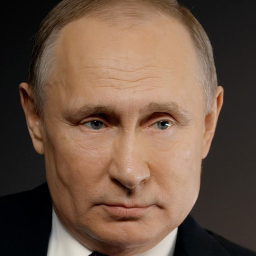

In [3]:
from ml4a import image
from ml4a.utils import face
from ml4a.models import idinvert

img = image.load_image('https://upload.wikimedia.org/wikipedia/commons/thumb/8/8d/Vladimir_Putin_%282020-02-20%29.jpg/1200px-Vladimir_Putin_%282020-02-20%29.jpg')
target_image, face_found = face.align_face(img, face_width=idinvert.resolution)  # match idinvert's resolution
image.display(target_image, title="Display target face")


After inverting the above image, we are going to "fuse" it onto some other "context" faces. We first load those context faces.

context faces


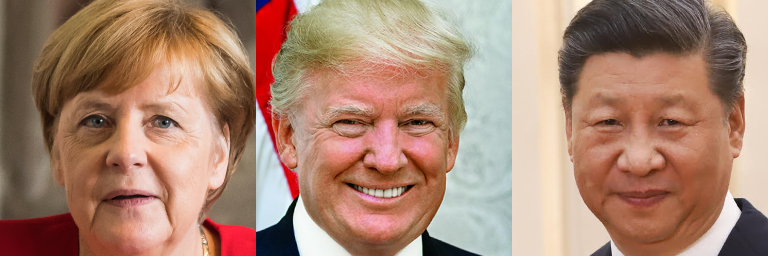

In [4]:
context_paths = [
    'https://upload.wikimedia.org/wikipedia/commons/a/a8/Angela_Merkel_2019_%28cropped%29.jpg',
    'https://bookstore.gpo.gov/sites/default/files/styles/product_page_image/public/covers/potus2_0.jpg',
    'https://upload.wikimedia.org/wikipedia/commons/3/32/Xi_Jinping_2019.jpg'    
]

context_images = []
for path in context_paths:
    img = image.load_image(path)
    aligned_face, face_found = face.align_face(img, face_width=idinvert.resolution)
    if face_found:
        context_images.append(aligned_face)

image.display(context_images, title="context faces")

`idinvert.fuse` will fuse the target face onto the context faces. You must specify `center_x`, `center_y`, and `crop_size`; these determine the coordinates of the bounding box onto which we will superimpose the target images. The bounding box will be a `crop_size * crop_size` square centered at (`center_x`, `center_y`).

[2020-11-30 23:28:02,920][INFO] Build network for module `generator` in model `styleganinv_ffhq256`.
[2020-11-30 23:28:03,093][INFO] Loading pytorch weights from `/home/bzion/.ml4a/models/idinvert_pytorch/pretrained/styleganinv_ffhq256_generator.pth`.
[2020-11-30 23:28:03,422][INFO] Successfully loaded!
[2020-11-30 23:28:05,159][INFO] Current `lod` is 0.0.
[2020-11-30 23:28:05,160][INFO] Build network for module `encoder` in model `styleganinv_ffhq256`.
[2020-11-30 23:28:05,967][INFO] Loading pytorch weights from `/home/bzion/.ml4a/models/idinvert_pytorch/pretrained/styleganinv_ffhq256_encoder.pth`.
[2020-11-30 23:28:07,826][INFO] Successfully loaded!


loss_pix: 0.005, loss_feat: 279.519, loss: 0.019: 100%|██████████| 100/100 [00:14<00:00,  7.01it/s]

superimposed images


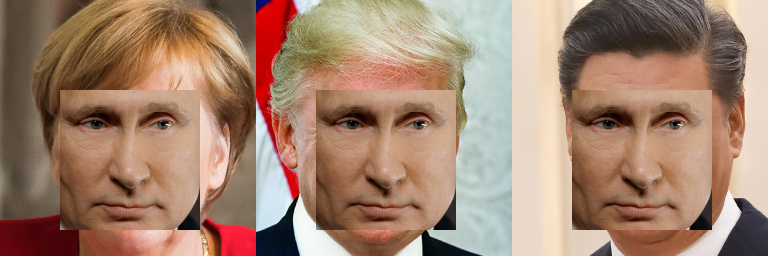

diffused images


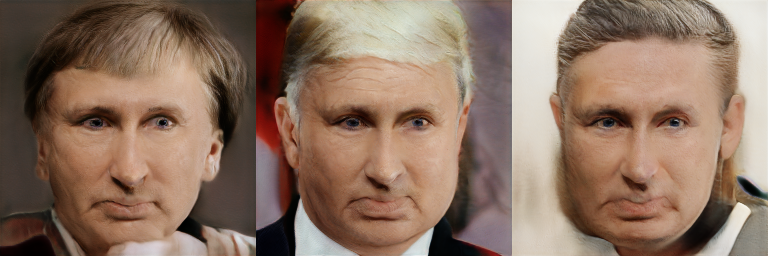

In [5]:
showed_fuses, diffused_images = idinvert.fuse('styleganinv_ffhq256', 
                                              context_images, target_image, 
                                              crop_size=140, center_x=130, center_y=160)
image.display(showed_fuses, title="superimposed images")
image.display(diffused_images, title="diffused images")

## In-domain editing

Another application of idinvert is to manipulate the features of a real image. We first project a real image (the same face sample as above) into the latent space of a pre-trained 256x256 StyleGAN2 trained on the ffqh dataset (faces). 

The function `idinvert.invert` runs an optimization to find a latent code which generates a face that looks as close to the original as possible.

In [6]:
latent_code = idinvert.invert('styleganinv_ffhq256', target_image, redo=False, save=False)

loss_pix: 0.036, loss_feat: 3385.471, loss_reg: 0.041, loss: 0.288:   0%|          | 0/100 [00:00<?, ?it/s]

optimizing latent_code to reconstruct target image...


loss_pix: 0.011, loss_feat: 1207.321, loss_reg: 0.009, loss: 0.090: 100%|██████████| 100/100 [00:08<00:00, 11.98it/s]


We then generate an image from the generator, using the latent code from the previous step. We can compare the "reconstructed" image to the original.

original and reconstruction


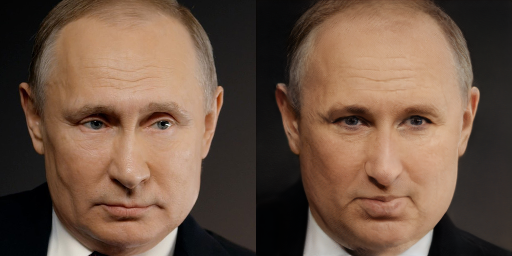

In [13]:
reconstruction = idinvert.generate('styleganinv_ffhq256', latent_code)
image.display([target_image, reconstruction[0]], title="original and reconstruction")

## Applying transformations

`idinvert` comes with several vectors which correspond to salient directions in the latent space of the GAN. By moving some distance along these directions from the latent vector from the previous step (`latent_code`), we can apply these feature transformations to the reconstruction.

In the case of the ffhq model, the directions are for age, eyeglasses, gender, head pose, and expression/smile. 

For example, the function `idinvert.age(latent_code, X)` will multiple the age vector by `X` and add it to the latent code `latent_code`. If `X` is positive, the resulting image should look older; if `X` is negative, then younger.

We demonstrate some examples in the next cell.

young to old


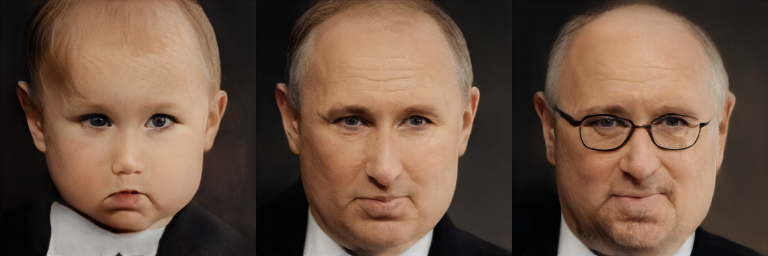

no eyeglasses to eyeglasses


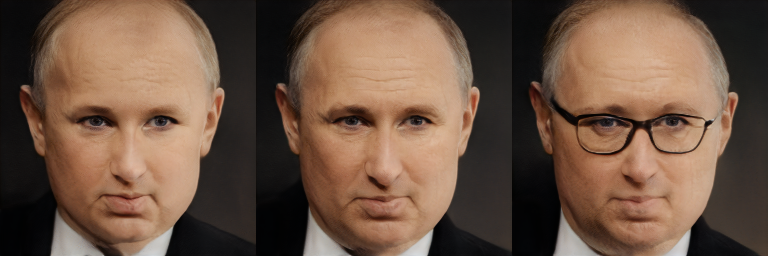

female to male


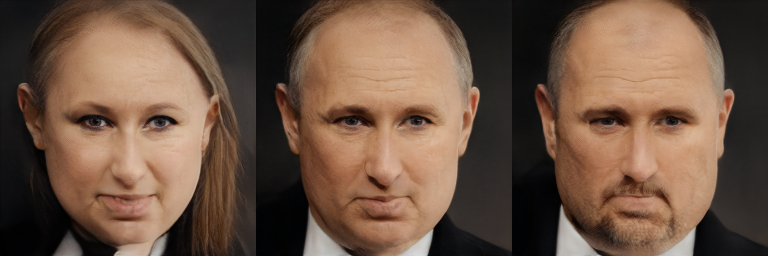

turning right to turning left


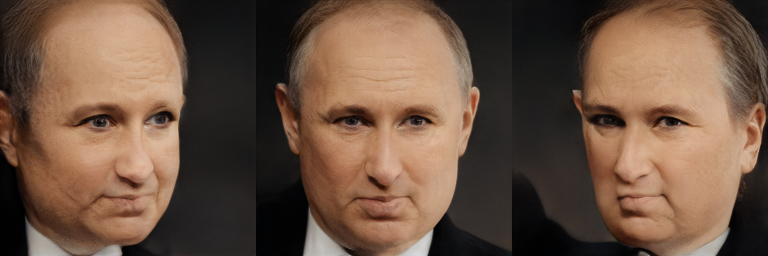

not smiling to smiling


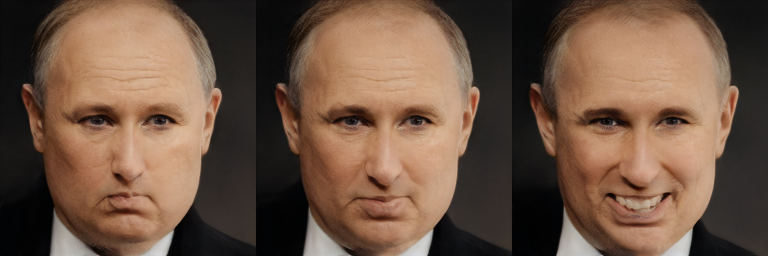

In [22]:
image.display([
    idinvert.generate('styleganinv_ffhq256', idinvert.age(latent_code, -2.0))[0],
    reconstruction[0],
    idinvert.generate('styleganinv_ffhq256', idinvert.age(latent_code, +2.0))[0]],
    title="young to old")

image.display([
    idinvert.generate('styleganinv_ffhq256', idinvert.eyeglasses(latent_code, -2.0))[0],
    reconstruction[0],
    idinvert.generate('styleganinv_ffhq256', idinvert.eyeglasses(latent_code, +2.0))[0]],
    title="no eyeglasses to eyeglasses")

image.display([
    idinvert.generate('styleganinv_ffhq256', idinvert.gender(latent_code, -2.0))[0],
    reconstruction[0],
    idinvert.generate('styleganinv_ffhq256', idinvert.gender(latent_code, +2.0))[0]],
    title="female to male")

image.display([
    idinvert.generate('styleganinv_ffhq256', idinvert.pose(latent_code, -2.0))[0],
    reconstruction[0],
    idinvert.generate('styleganinv_ffhq256', idinvert.pose(latent_code, +2.0))[0]],
    title="turning right to turning left")

image.display([
    idinvert.generate('styleganinv_ffhq256', idinvert.expression(latent_code, -2.0))[0],
    reconstruction[0],
    idinvert.generate('styleganinv_ffhq256', idinvert.expression(latent_code, +2.0))[0]],
    title="not smiling to smiling")


Since the transition is continuous, we can animate it. Below we interpolate between the two extremes of age.

In [24]:
import numpy as np

frames = [idinvert.generate('styleganinv_ffhq256', idinvert.age(latent_code, r))[0] 
          for r in np.linspace(-2.0, +2.0, 60)]
image.display(frames, animate=True, title="Age range")

Same thing, but for expression (smile).

In [25]:
frames = [idinvert.generate('styleganinv_ffhq256', idinvert.expression(latent_code, r))[0] 
          for r in np.linspace(-3.0, +3.0, 60)]
image.display(frames, animate=True, title="Expression range")